#  Neural Networks for Music Classification

In addition to the concepts in the MNIST neural network demo, in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Record the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

## Installing and Loading the Keras package

Before beginning you need to make sure you have installed tensorflow and keras.  Full instructions are available:
*  [Tensorflow installation page](https://www.tensorflow.org/install/)
*  [Keras installation page](https://keras.io/#installation)

For the most part, you should be able to install both with the commands:
     
    pip3 install --upgrade tensorflow
    pip3 install --upgrade keras
    
After you have installed the packages, we can begin by loading keras and the other packages

In [28]:
import keras

In [29]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

## Audio Feature Extraction with Librosa

The key to audio classification is to extract the correct features. In addition to `keras`, we will need the `librosa` package.  The `librosa` package in python has a rich set of methods extracting the features of audio samples commonly used in machine learning tasks such as speech recognition and sound classification. 

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  On most systems, you should be able to simply use:

    pip install -u librosa
    
For Unix, you may need to load some additional packages:

    sudo apt-get install build-essential
    sudo apt-get install libxext-dev python-qt4 qt4-dev-tools
    pip install librosa
    
After you have installed the package, try to import it.

In [30]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has a great set of samples for audio processing.  Look on the web for how to use the `requests.get` and `file.write` commands to load the file at the URL provided into your working directory.

You can play the audio sample by copying the file to your local machine and playing it on any media player.  If you listen to it you will hear a soprano saxaphone (with vibrato) playing four notes (C, C#, D, Eb).

In [31]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn


# TODO:  Load the file from url and save it in a file under the name fn
r = requests.get(url)
print(r.status_code)
print(r.encoding)

with open(fn, 'wb') as fd:
    for chunk in r.iter_content(chunk_size=1024):
        fd.write(chunk)

200
None


Next, use `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [32]:
# TODO
# y, sr = ...
y, sr = librosa.load(fn)

Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called mel spectrogram which is something like a regular spectrogram, but the power and frequency are represented in log scale, which more naturally aligns with human perceptual processing.  You can run the code below to display the mel spectrogram from the audio sample.

You can easily see the four notes played in the audio track.  You also see the 'harmonics' of each notes, which are other tones at integer multiples of the fundamental frequency of each note.

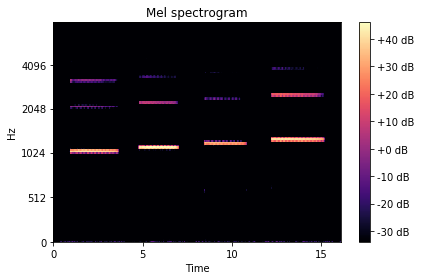

In [33]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above.  For each audio file, the segmented the track into notes and then extracted 120 MFCCs for each note.  The goal is to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say  `instrument_dataset`.  Then, load them with the commands.

In [34]:
data_dir = 'instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

Looking at the data files:
* What are the number of training and test samples?
* What is the number of features for each sample?
* How many classes (i.e. instruments) are there per class?


In [35]:
# TODO
print(Xtr.shape)
print(ytr.shape)
print(Xts.shape)
print(yts.shape)
print('We have %d training samples' %ytr.shape)
print('We have %d test samples' %yts.shape)
print('We have %d features for each sample' %Xtr.shape[1])
print(np.unique(ytr), 'We have 10 instruments')

(66247, 120)
(66247,)
(14904, 120)
(14904,)
We have 66247 training samples
We have 14904 test samples
We have 120 features for each sample
[0 1 2 3 4 5 6 7 8 9] We have 10 instruments


Before continuing, you must scale the training and test data, `Xtr` and `Xts`.  Compute the mean and std deviation of each feature in `Xtr` and create a new training data set, `Xtr_scale`, by subtracting the mean and dividing by the std deviation.  Also compute a scaled test data set, `Xts_scale` using the mean and std deviation learned from the training data set.

In [36]:
# TODO Scale the training and test matrices
# Xtr_scale = ...
# Xts_scale = ...
Xtr_scale = preprocessing.scale(Xtr)
Xts_scale = preprocessing.scale(Xts)

## Building a Neural Network Classifier

Following the example in MNIST neural network demo posted on CCLE on May 24th (there is both a pdf file and a python notebook file; you can save the python notebook file and open it in Jupyter or similiar tool), clear the keras session.  Then, create a neural network `model` with:
* `nh=256` hidden units
* `sigmoid` activation
* select the input and output shapes correctly
* print the model summary

In [37]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

In [38]:
# Clear session (removes existing models)
import keras.backend as K  # From demo (so you can use K.xxx instead of typing keras.backend.xxx)
K.clear_session()   

In [40]:
# TODO: construct the model
nin = Xtr.shape[1] #dimension of input data
nh = 256 #number of hidden units
nout = int(np.max(ytr) + 1)  #number of outputs = 10 since there are 10 instruments
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation = 'softmax', name='output'))

In [41]:
# TODO:  Print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               30976     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________


Create an optimizer and compile the model.  Select the appropriate loss function and metrics.  For the optimizer, use the Adam optimizer with a learning rate of 0.001

In [43]:
# TODO
# opt = ...
# model.compile(...)
from keras import optimizers

opt = optimizers.Adam(lr = 0.001)
model.compile(optimizer=opt,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

Fit the model for 10 epochs using the scaled data for both the training and validation.  Use the `validation_data` option to pass the test data.  Use a batch size of 100.  Your final accuracy should be >99%.  To record the training history, use

     hist = model.fit(...)
     
This will return a data structure, `hist` with the metrics per epoch.

In [48]:
# TODO
# hist = model.fit(...)
hist = model.fit(Xtr, ytr, epochs=10, batch_size=100, validation_data=(Xts,yts))

Train on 66247 samples, validate on 14904 samples
Epoch 1/10
66247/66247 [==============================] - 3s 40us/step - loss: 1.4605 - acc: 0.5162 - val_loss: 1.4951 - val_acc: 0.5391
Epoch 2/10
66247/66247 [==============================] - 2s 32us/step - loss: 0.9960 - acc: 0.6783 - val_loss: 1.1003 - val_acc: 0.6398
Epoch 3/10
66247/66247 [==============================] - 2s 34us/step - loss: 0.7336 - acc: 0.7685 - val_loss: 0.8343 - val_acc: 0.7403
Epoch 4/10
66247/66247 [==============================] - 2s 31us/step - loss: 0.5677 - acc: 0.8285 - val_loss: 0.6557 - val_acc: 0.7882
Epoch 5/10
66247/66247 [==============================] - 2s 31us/step - loss: 0.4552 - acc: 0.8685 - val_loss: 0.5220 - val_acc: 0.8506
Epoch 6/10
66247/66247 [==============================] - 2s 33us/step - loss: 0.3745 - acc: 0.8962 - val_loss: 0.4135 - val_acc: 0.8843
Epoch 7/10
66247/66247 [==============================] - 2s 32us/step - loss: 0.3161 - acc: 0.9163 - val_loss: 0.3566 - val_acc

The data structure `hist` should contain the training and validation accuracy as a function of the epoch:
*  `hist.history['acc']`:  Training accuracy per epoch
*  `hist.history['val_acc']`:  Test/validation accuracy per epoch

Plot the training and test validation as a function of the epoch.  Label your graph.

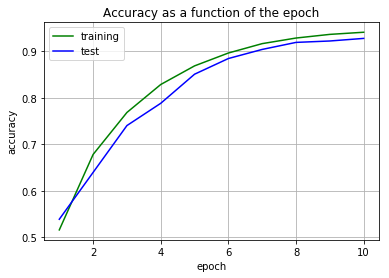

In [80]:
# TODO

epochs = np.arange(1,11,1)
name = ['training', 'test']

plt.plot(epochs, hist.history['acc'], color='green')
plt.plot(epochs, hist.history['val_acc'], color='blue')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy as a function of the epoch')
plt.grid()
plt.legend(name, loc='best')

Plot the loss function, stored in `hist.history['loss']`.

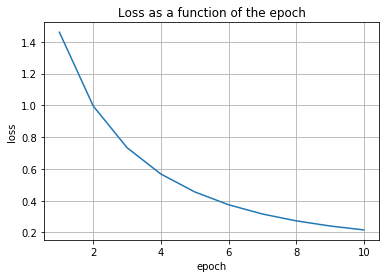

In [82]:
# TODO
plt.plot(epochs, hist.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss as a function of the epoch')
plt.grid()

## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Rerun the above code, trying four learning rates as shown in the vector `rates`.  For each learning rate:
* clear the session
* construct the network
* select the optimizer.  Use the Adam optimizer with the appropriate learrning rate.
* train the model
* save the accuracy and losses

In [107]:
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = np.zeros((3, 10))
val_acc_hist = np.zeros((3, 10))

# TODO
for i, rate in enumerate(rates, 1):
    K.clear_session()
    nin = Xtr.shape[1] #dimension of input data
    nh = 256 #number of hidden units
    nout = int(np.max(ytr) + 1)  #number of outputs = 10 since there are 10 instruments
    model = Sequential()
    model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
    model.add(Dense(nout, activation = 'softmax', name='output'))
    
    opt = optimizers.Adam(lr = rate)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    hist = model.fit(Xtr, ytr, epochs=10, batch_size=100, validation_data=(Xts,yts))
    loss_hist[i-1] = hist.history['loss']
    val_acc_hist[i-1] = hist.history['val_acc']
    
print(loss_hist)
print(val_acc_hist)
    
    
    

Train on 66247 samples, validate on 14904 samples
Epoch 1/10
66247/66247 [==============================] - 2s 32us/step - loss: 0.6790 - acc: 0.7846 - val_loss: 0.3349 - val_acc: 0.9008
Epoch 2/10
66247/66247 [==============================] - 2s 29us/step - loss: 0.2030 - acc: 0.9395 - val_loss: 0.2004 - val_acc: 0.9353
Epoch 3/10
66247/66247 [==============================] - 2s 30us/step - loss: 0.1255 - acc: 0.9616 - val_loss: 0.1613 - val_acc: 0.9444
Epoch 4/10
66247/66247 [==============================] - 2s 29us/step - loss: 0.0895 - acc: 0.9734 - val_loss: 0.1271 - val_acc: 0.9586
Epoch 5/10
66247/66247 [==============================] - 2s 30us/step - loss: 0.0695 - acc: 0.9787 - val_loss: 0.1192 - val_acc: 0.9626
Epoch 6/10
66247/66247 [==============================] - 2s 30us/step - loss: 0.0580 - acc: 0.9823 - val_loss: 0.0936 - val_acc: 0.9727
Epoch 7/10
66247/66247 [==============================] - 2s 29us/step - loss: 0.0477 - acc: 0.9857 - val_loss: 0.0804 - val_acc

Plot the loss function vs. the epoch number for all three learning rates on one graph.  In order that you can see the difference, it may be useful to plot them using `semilogy` so that the loss is in log scale. You should see that the lower learning rates are more stable, but converge slower.

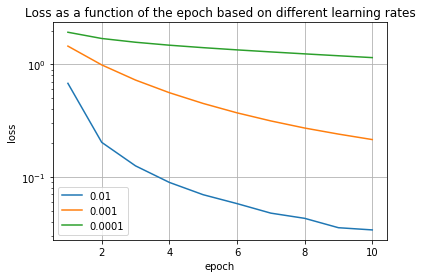

In [132]:
# TODO
#loss_hist
colors = ['green', 'blue', 'red']
epochs = np.arange(1,11,1)
for i in range(3):
    plt.semilogy(epochs, loss_hist[i,])

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss as a function of the epoch based on different learning rates')
plt.grid()    
plt.legend(rates, loc='best')